# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1Q5nNzFjZM19GyP8BsQlJjpmbKkiRlHkO?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:03<00:00, 46890940.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

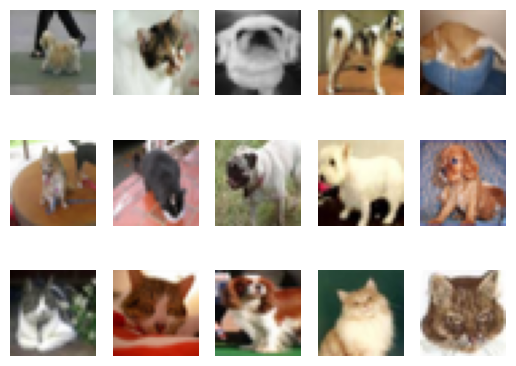

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
'''Because the CIFAR-10 dataset has 50,000 training images over all classes, and because there are
10 total classes, we get'''
total_training_images_per_class = 50000/10 #5000 training images per class
'''Out of these training images, our model splits 80% of the training data for initial training, and
the remaining 20% for validation. Therefore:'''
training_model_cats_dogs = 2 * total_training_images_per_class * 0.8 #8000 training images for the combined cats and dogs classes
validation_model_cats_dogs = 2* total_training_images_per_class - training_model_cats_dogs #2000 validation images for the combined cats and dogs classes

### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
'''We need a validation set when training our model to tune and control the model after it has been
trained, which helps in reducing bias in the model and show how well the model is learning and
adapting. If we judge the performance of models using training set error instead of the validation
set error, we would have a greatly biased evaluation of the model making it seem like it is better
than it actually is because the training set is the data that the model uses to learn initially,
so the error on it will be much lower than the error when it is exposed to a brand new dataset with
different data points, but the same TYPE of data.'''

'We need a validation set when training our model to tune and control the model after it has been\ntrained, which helps in reducing bias in the model and show how well the model is learning and\nadapting. If we judge the performance of models using training set error instead of the validation\nset error, we would have a greatly biased evaluation of the model making it seem like it is better\nthan it actually is because the training set is the data that the model uses to learn initially,\nso the error on it will be much lower than the error when it is exposed to a brand new dataset with\ndifferent data points, but the same TYPE of data.'

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)
print("-")
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
-
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


In [ ]:
print("The total number of parameters in small_net is " + str(5*3*3*3 + 5 + 1*245 + 1))
print("The total number of parameters in large_net is " + str(5*3*5*5 + 5 + 10*5*5*5 + 10 + 32*250 + 32 + 1*32 + 1))

The total number of parameters in small_net is 386
The total number of parameters in large_net is 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

In [ ]:
#Default values:
batch_size = 64
learning_rate = 0.01
num_epochs = 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(net = small_net, num_epochs = 5)

'''Files written to disk:
model_small_bs64_lr0.01_epoch0 - checkpoint for epoch 0
model_small_bs64_lr0.01_epoch1 - checkpoint for epoch 1
model_small_bs64_lr0.01_epoch2 - checkpoint for epoch 2
model_small_bs64_lr0.01_epoch3 - checkpoint for epoch 3
model_small_bs64_lr0.01_epoch4 - checkpoint for epoch 4
model_small_bs64_lr0.01_epoch4_train_err.csv - contains the training error of small_net after the 5th epoch
model_small_bs64_lr0.01_epoch4_train_loss.csv - contains the training loss of small_net after the 5th epoch
model_small_bs64_lr0.01_epoch4_val_err.csv - contains the validation error of small_net after the 5th epoch
model_small_bs64_lr0.01_epoch4_val_loss.csv - contains the validation loss of small_net after the 5th epoch
NOTE: Checkpoints contain the saved values of model weights at the end of each epoch
'''

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.435625, Train loss: 0.6780269684791564 |Validation err: 0.3855, Validation loss: 0.6619277559220791
Epoch 2: Train err: 0.37125, Train loss: 0.6498568053245545 |Validation err: 0.3705, Validation loss: 0.649108313024044
Epoch 3: Train err: 0.360125, Train loss: 0.6389743585586548 |Validation err: 0.348, Validation loss: 0.6286267787218094
Epoch 4: Train err: 0.346, Train loss: 0.6269212069511414 |Validation err: 0.3465, Validation loss: 0.6244188211858273
Epoch 5: Train err: 0.343375, Train loss: 0.618819887638092 |Validation err: 0.342, Validation loss: 0.6168233416974545
Finished Training
Total time elapsed: 32.67 seconds


'Files written to disk:\nmodel_small_bs64_lr0.01_epoch0 - checkpoint for epoch 0\nmodel_small_bs64_lr0.01_epoch1 - checkpoint for epoch 1\nmodel_small_bs64_lr0.01_epoch2 - checkpoint for epoch 2\nmodel_small_bs64_lr0.01_epoch3 - checkpoint for epoch 3\nmodel_small_bs64_lr0.01_epoch4 - checkpoint for epoch 4\nmodel_small_bs64_lr0.01_epoch4_train_err.csv - contains the training error of small_net after the 5th epoch\nmodel_small_bs64_lr0.01_epoch4_train_loss.csv - contains the training loss of small_net after the 5th epoch\nmodel_small_bs64_lr0.01_epoch4_val_err.csv - contains the validation error of small_net after the 5th epoch\nmodel_small_bs64_lr0.01_epoch4_val_loss.csv - contains the validation loss of small_net after the 5th epoch\nNOTE: Checkpoints contain the saved values of model weights at the end of each epoch\n'

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_net(small_net)
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.3295, Train loss: 0.6080470056533813 |Validation err: 0.3335, Validation loss: 0.6122405398637056
Epoch 2: Train err: 0.32325, Train loss: 0.6009767365455627 |Validation err: 0.3385, Validation loss: 0.6266951262950897
Epoch 3: Train err: 0.317625, Train loss: 0.5949181377887726 |Validation err: 0.3205, Validation loss: 0.5982526857405901
Epoch 4: Train err: 0.310375, Train loss: 0.585449330329895 |Validation err: 0.3165, Validation loss: 0.5960524678230286
Epoch 5: Train err: 0.30775, Train loss: 0.5802813990116119 |Validation err: 0.316, Validation loss: 0.5912606567144394
Epoch 6: Train err: 0.307125, Train loss: 0.5763311166763305 |Validation err: 0.3185, Validation loss: 0.5903457440435886
Epoch 7: Train err: 0.30225, Train loss: 0.5728312101364136 |Validation err: 0.324, Validation loss: 0.5841693449765444
Epoch 8: Train err: 0.2975, Train loss: 0.5678883669376373 |Validation err: 0.

**`small_net` reported a total time elapsed of 148.57 seconds and `large_net` reported a total time elapsed of 160.40 seconds. `large_net` took longer to train because it had more layers and thus more parameters (as reported above), so the training process required more parameters to be updated at each epoch, which increased the time taken for each individual epoch, and thus increasing the overall training time.**

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

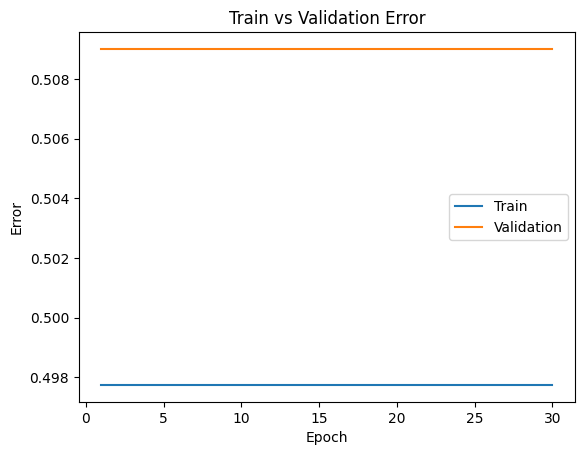

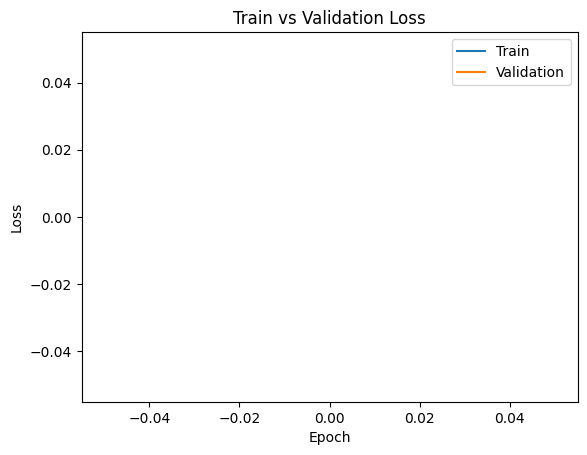

-------------------------------------------------------------------------


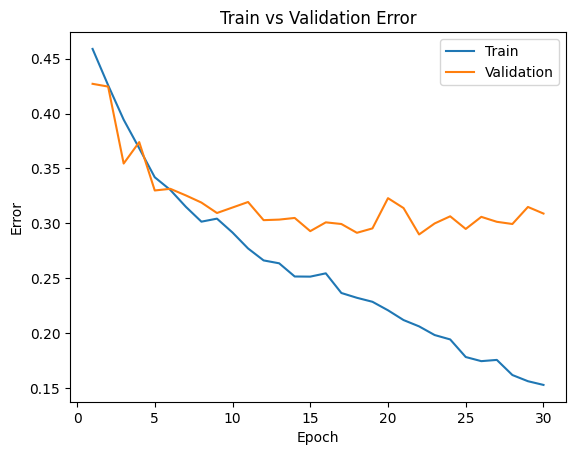

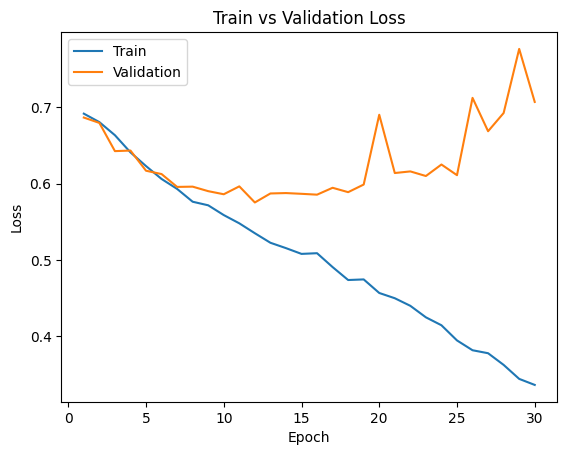

In [ ]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)
small_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(small_path)
print("-------------------------------------------------------------------------")
large_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(large_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
'''The training curve for small_net maintains a consistent training error of 0.49775 and a consistent validation error of 0.509, which is much higher than the maximum training and validation errors of large_net, which has decreasing training
and validation errors over each epoch, although the validation error seems to begin to increase again after ~22 epochs, although it never reaches its previous maxima. There is also no Train vs. Validation Loss curve for small_net, as the training and validation loss calculations for small_net return 'nan' (not a number - see part (d)) meaning that for some reason the values can't
be computed (possibly due to the insane magnitude they may possess, as discussed below),  whereas by contrast, we see that large_net has a decreasing Train loss but increasing Validation loss after an initial drop and rough plateau between
8 to 15 epochs.
This clearly demonstrates that small_net is an underfit model, as it has high training and validation error, and is so simplistic that it cannot even generate any sort of comprehensible training or validation loss data, which is by definition
an underfit model (so simplistic that it returns high error). Meanwhile large_net seems to possess some overfitting, as its validation loss begins while it maintains rapidly decreasing training error and loss, its validation loss appears to
increase after ~15 epochs, and its validation error also appears to start to pleateau and increase after ~22 epochs, which indicates that the model fits extremely well to the training data but not to much else, a classic symptom of
overfitting.'''

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

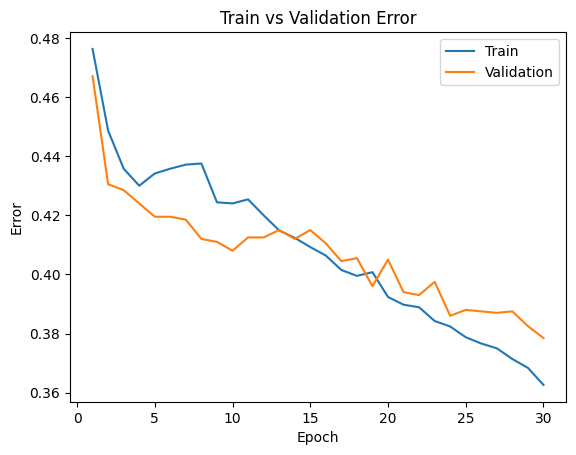

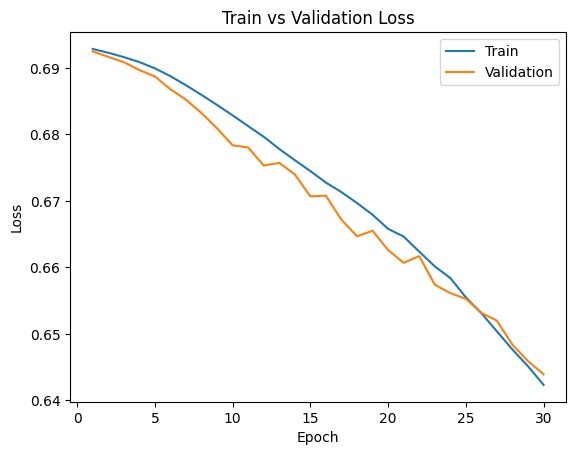

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(net=large_net, learning_rate=0.001)
large_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_path)

**Lowering the learning rate increases the time taken to 163.60 seconds (from 160.40 seconds with `learning_rate = 0.01`); however, it also significantly decreases the amount of overfitting occurring in the model and creates a better trained model, with both the Train and Validation errors and losses decreasing rapidly, and overall much more improvement of fitting noticed with drastic decreases in validation error and loss. Thus, in sum, lowering the learning rate better fits the model at the cost of a few seconds.**

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

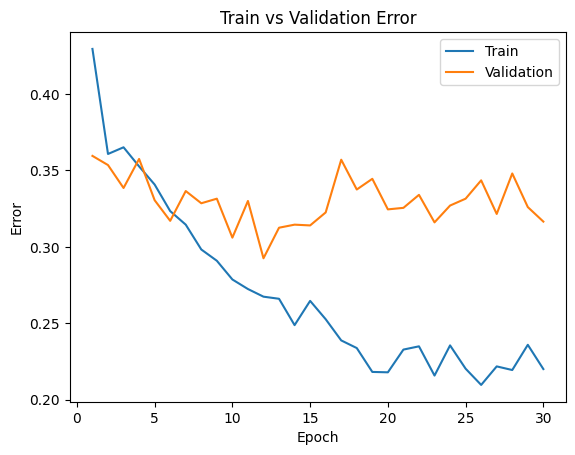

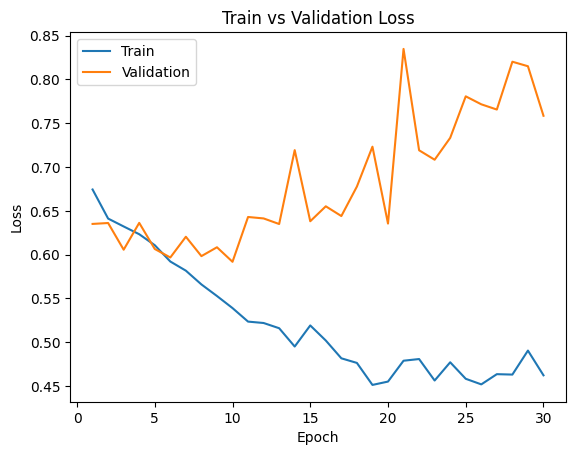

In [ ]:
large_net = LargeNet()

train_net(net=large_net, learning_rate=0.1)
large_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_path)

**The model now takes slightly more time to train than the original learning rate of 0.01, but less time to train than the learning rate of 0.001, reporting a total time of 161.74 seconds. However, it also performs significantly worse than both the models with learning rates of 0.01 and 0.001, demonstrating an *increasing* validation loss for progressing epochs. Thus, increasing the learning rate decreases the accuracy of the model, and still takes more time than the learning rate of 0.01.**

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

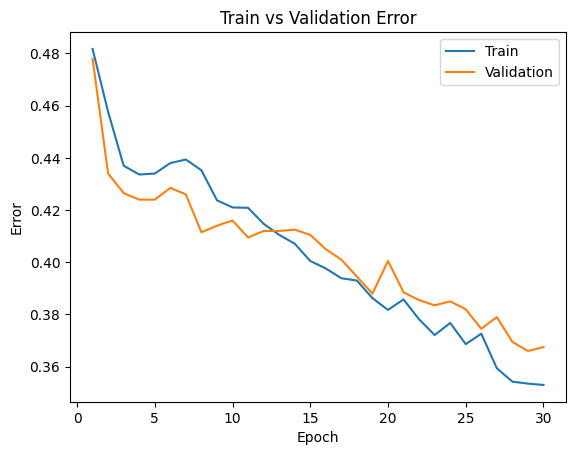

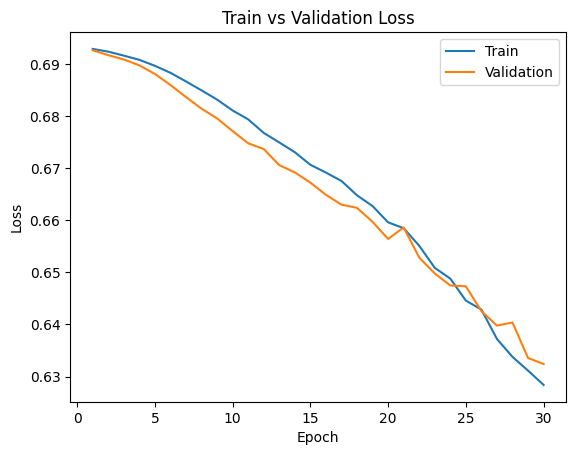

In [ ]:
large_net = LargeNet()

train_net(net=large_net, batch_size=512)
large_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_path)

**The model now takes shorter to train, completing training in 142.88 seconds. It also exhibits better fitting than the previous batch_size of 64, demonstrating rapidly decreasing training and validation errors and losses, and thus is not too overfitted or underfitted. Thus, increasing the batch size creates a huge improvement on the accuracy and efficiency of the model.**

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

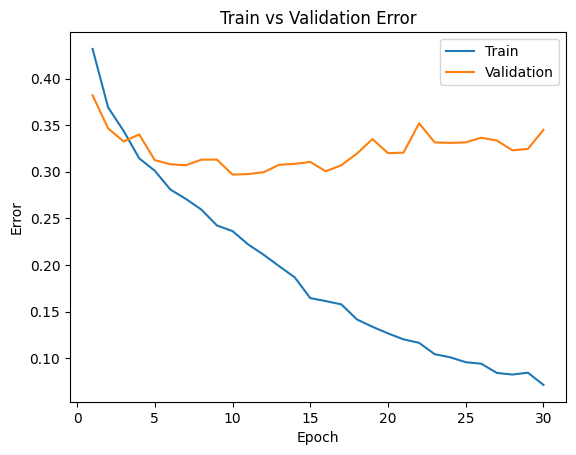

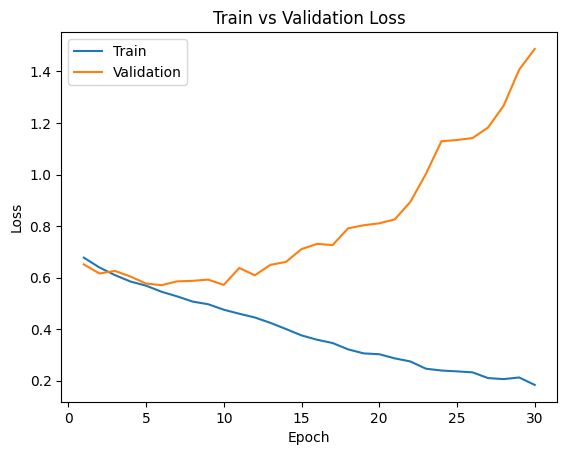

In [ ]:
large_net = LargeNet()

train_net(net=large_net, batch_size=16)
large_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_path)

**Decreasing the batch size made it take longer to train, increasing the total time elapsed to 217.53 seconds (the highest so far), while also decreasing the accuracy of the model and demonstrating severe overfitting, since the training error and loss decrease rapidly for increasing epochs, but the validation error decreases slightly, plateaus, and then begins to increase again, and the validation loss increases rapidly during the training process. Thus, decreasing the batch size makes the model severely inaccurate, overfitted, and inefficient.**

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
network = LargeNet()
batch_size = 700
learning_rate = 0.001
'''I picked these values because based on the plots above, large_net is more accurate than small_net, since it has more parameters to train and thus can extract more information and higher quality information out of the data, increasing the
batch size increased both accuracy and thus the fitting of the model and efficiency, while the learning rate of 0.001 also helps to better fit the model for the tradeoff of a little bit of time. However, that temporal increase is balanced out
theoretically by the time decrease from the increased batch size, so these values significantly increase the model's accuracy and fit without a significant temporal tradeoff.'''

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49725, Train loss: 0.6937709798415502 |Validation err: 0.504, Validation loss: 0.6942088007926941
Epoch 2: Train err: 0.497, Train loss: 0.6936662693818411 |Validation err: 0.504, Validation loss: 0.6940996050834656
Epoch 3: Train err: 0.49675, Train loss: 0.6936365564664205 |Validation err: 0.5025, Validation loss: 0.6939947207768759
Epoch 4: Train err: 0.4965, Train loss: 0.6935847202936808 |Validation err: 0.5025, Validation loss: 0.693956991036733
Epoch 5: Train err: 0.496875, Train loss: 0.6934573849042257 |Validation err: 0.5005, Validation loss: 0.6938021183013916
Epoch 6: Train err: 0.496875, Train loss: 0.6934417535861334 |Validation err: 0.502, Validation loss: 0.6936893661816915
Epoch 7: Train err: 0.49625, Train loss: 0.6933341572682062 |Validation err: 0.506, Validation loss: 0.6935935020446777
Epoch 8: Train err: 0.496375, Train loss: 0.6932598501443863 |Validation err: 0.501

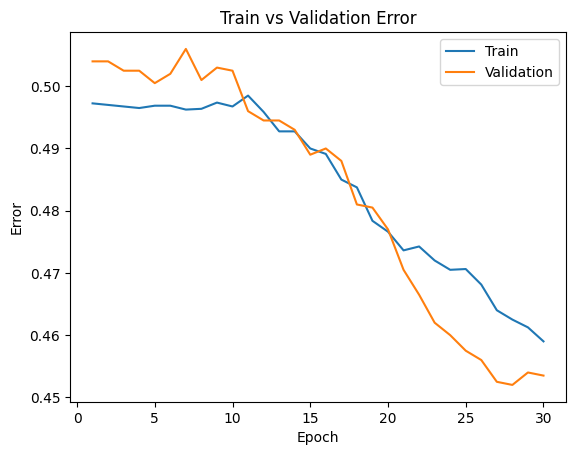

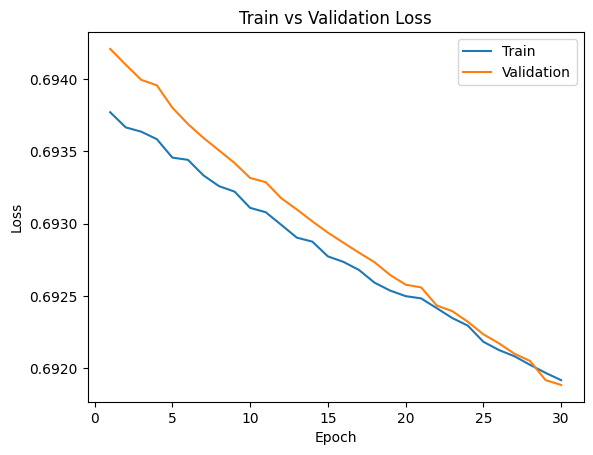

In [ ]:
large_net = LargeNet()

train_net(net=large_net, batch_size=700, learning_rate=0.001)
large_path = get_model_name("large", batch_size=700, learning_rate=0.001, epoch=29)
plot_training_curve(large_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

In [ ]:
network = LargeNet()
batch_size = 900
learning_rate = 0.001
'''The results above seem positive, so this is now doubling down on everything down above with an even higher batch size and even lower learning rate.'''

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.488875, Train loss: 0.6930699414677091 |Validation err: 0.496, Validation loss: 0.6931130886077881
Epoch 2: Train err: 0.48725, Train loss: 0.6930334236886766 |Validation err: 0.496, Validation loss: 0.6930189530054728
Epoch 3: Train err: 0.485, Train loss: 0.693001925945282 |Validation err: 0.4965, Validation loss: 0.6930164098739624
Epoch 4: Train err: 0.48275, Train loss: 0.6929701699150933 |Validation err: 0.495, Validation loss: 0.6933522423108419
Epoch 5: Train err: 0.48, Train loss: 0.6929284201727973 |Validation err: 0.491, Validation loss: 0.692748486995697
Epoch 6: Train err: 0.478375, Train loss: 0.6928779416614108 |Validation err: 0.492, Validation loss: 0.6928690274556478
Epoch 7: Train err: 0.477, Train loss: 0.6928358674049377 |Validation err: 0.4875, Validation loss: 0.6931058565775553
Epoch 8: Train err: 0.473375, Train loss: 0.6927957468562655 |Validation err: 0.4845, Val

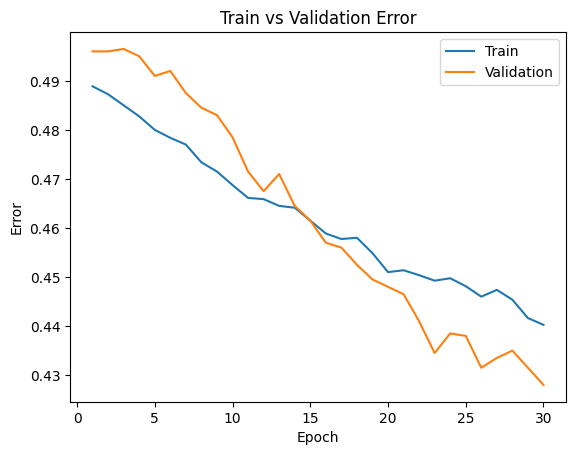

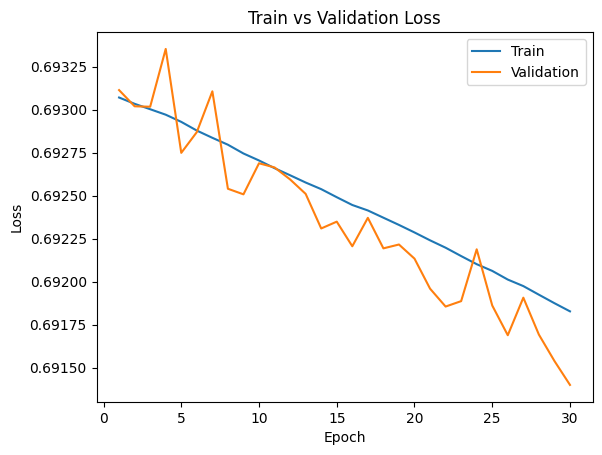

In [ ]:
large_net = LargeNet()

train_net(net=large_net, batch_size=900, learning_rate=0.001)
large_path = get_model_name("large", batch_size=900, learning_rate=0.001, epoch=29)
plot_training_curve(large_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = SmallNet()
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=10)
state = torch.load(model_path)
net.load_state_dict(state)

In [ ]:
#Best model:

net = LargeNet()
model_path = get_model_name(net.name, batch_size=900, learning_rate=0.001, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
'''This model had the lowest training and validation errors and losses, and therefore the best fitting and accuracy, while also having the fastest training time, thus making this the best choice of model.'''

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=900)

test_err, test_loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print("Test Error: ", test_err, "Test Loss: ", test_loss)

Files already downloaded and verified
Files already downloaded and verified
Test Error:  0.432 Test Loss:  0.691737155119578


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
'''The test error is slightly higher than the validation error, being 0.4335 compared to 0.426 at the end of the 30th epoch. This is expected because the test data is data that the model has never seen before, and it is only going through it
once, so it is likely to make more errors than with the validation data, which it is seeing in multiple epochs and revising its learning using it in each epoch. It is akin to taking a real test (test set) vs a practice test (validation set) - in the practice test, you
revise questions you got wrong in the first attempt and keep attempting until you get everything as right as you can before the real test begins. However, in the real test, there will always be some question that will stump you because it is
either too different from the practice test or you couldn't make the connection, so the error rate on the real test will be higher than the practice test.'''

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
'''The test set was used at the very end to test how well the best version of our model was able to learn and be fine-tuned after the specified number of epochs, and thus how well it can generalize its knowledge to data it has never seen before.
It is crucial to use the test data as little as possible because the more the test data is reviewed, the more the model will begin to learn it and the poorer of an indicator it will be for the model's generalization ability. Using the "real
test vs. practice test" analogy from before, the more times a student retakes a test, the higher they will score on the test, but it may not because their generalization ability improved, but rather because they "learned the test". It is
of course always possible that the student's generalization ability has also improved, but that cannot be determined until they are given ANOTHER test that they will have seen for the first time.'''

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.499125, Train loss: 0.6962915990087721 |Validation err: 0.5, Validation loss: 0.6980075041453043
Epoch 2: Train err: 0.48525, Train loss: 0.692088438404931 |Validation err: 0.4755, Validation loss: 0.6908339262008667
Epoch 3: Train err: 0.461, Train loss: 0.6879125369919671 |Validation err: 0.4495, Validation loss: 0.6865282654762268
Epoch 4: Train err: 0.442875, Train loss: 0.6841277943717109 |Validation err: 0.4285, Validation loss: 0.6850360433260599
Epoch 5: Train err: 0.429875, Train loss: 0.681184622976515 |Validation err: 0.4235, Validation loss: 0.6801959872245789
Epoch 6: Train err: 0.425, Train loss: 0.6785153746604919 |Validation err: 0.42, Validation loss: 0.6804686784744263
Epoch 7: Train err: 0.419, Train loss: 0.6763131552272372 |Validation err: 0.4185, Validation loss: 0.6800350546836853
Epoch 8: Train err: 0.41225, Train loss: 0.6742619077364603 |Validation err: 0.4155, Va

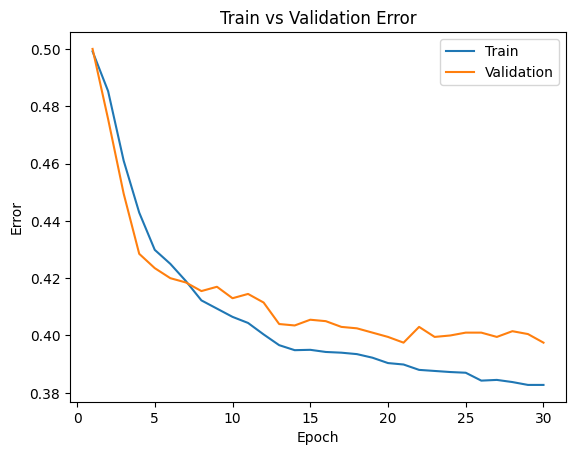

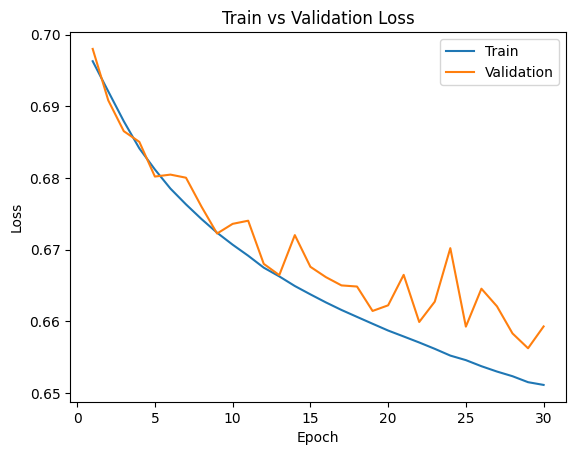

In [ ]:
torch.manual_seed(1000) # set the random seed

# define a 2-layer artificial neural network
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ann"
        self.layer1 = nn.Linear(3 * 32 * 32, 32)
        self.layer2 = nn.Linear(32, 1)
    def forward(self, x):
        flattened = x.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

ann = ANN()

train_net(net=ann, batch_size=900, learning_rate=0.001)
ann_path = get_model_name("ann", batch_size=900, learning_rate=0.001, epoch=29)
plot_training_curve(ann_path)

In [ ]:
net = ANN()
model_path = get_model_name(net.name, batch_size=900, learning_rate=0.001, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=900)

test_err, test_loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print("Test Error: ", test_err, "Test Loss: ", test_loss)

Files already downloaded and verified
Files already downloaded and verified
Test Error:  0.379 Test Loss:  0.6517025232315063


**The CNN fares better than the ANN because while the ANN takes less time than the CNN to train, the CNN has a much lower test error and loss than the ANN, reporting better accuracy for the same parameters, despite the ANN being the best possible version of the model. In fact, it is only after ~5 reruns of the test set (as an experiment to see how fast the model stops generalizing) that I was able to get the above test error and loss lower than that of the CNN.**